In [1]:
# This file will include the visual representations of microstrucre outputs 

In [2]:
# this file is under the docs, come out of the shell to reach every file design 

In [3]:
import os
os.chdir('../')  # go one step back
cwd = os.getcwd()
cwd

'C:\\Users\\talha\\Desktop\\Microstructure-Generation'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
from vae.dataset import MicrostructureDataset
root_dir = "./dataset/dataset_z9.hdf5" 
dataset = MicrostructureDataset(root_dir)

In [5]:
# Split data into 3 parts 
ratio = list(map(int,[0.7*len(dataset), 0.2*len(dataset), 0.1*len(dataset)]))
train, test ,validation = random_split(dataset, ratio)
train

====> image!


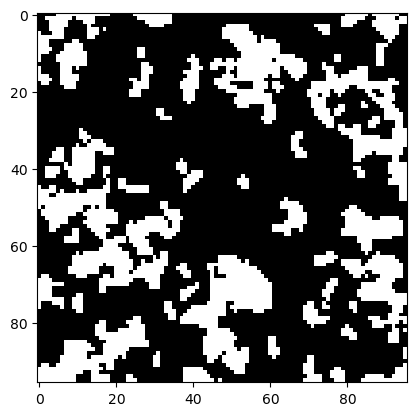

In [6]:
dataset.visualize(train[0])

In [7]:
# Linear to Linear Autoencoder 

In [9]:
#library imports 
import torch.nn as nn
import torch.nn.functional as F
import torch 
# Macros
dropout_keep_rate= 0.66
features = 9
images_size = 96
#Paths
class VAEModel(nn.Module):
    
        #List of Modules
        env = []
        dropout = []
        batch = []
        
        
        dec = []
        dec_drop = []
        dec_batch = []

        def __init__(self):
            super(VAEModel, self).__init__()
            
            self.env1 = nn.Linear(in_features=images_size*images_size, out_features=256)
            self.env.append(self.env1)
            self.env2 = nn.Linear(in_features=256, out_features=64)
            self.env.append(self.env2)
            self.env3 =nn.Linear(in_features=64, out_features=features*2)
            self.env.append(self.env3)        

            self.dropout1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout1)       
            self.dropout2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout2)     
            self.dropout3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout3)
            
            self.batch1=nn.BatchNorm1d(256) 
            self.batch.append(self.batch1)        
            self.batch2=nn.BatchNorm1d(64)
            self.batch.append(self.batch2)
            self.batch3=nn.BatchNorm1d(features*2)
            self.batch.append(self.batch3)            

            # decoder 
            self.dec1 = nn.Linear(in_features=features, out_features=64)
            self.dec.append(self.dec1)
            self.dec2 = nn.Linear(in_features=64, out_features=256)
            self.dec.append(self.dec2)
            self.dec3 = nn.Linear(in_features=256, out_features=images_size*images_size)
            self.dec.append(self.dec3)


            self.dec_drop1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop1)
            self.dec_drop2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop2)
            self.dec_drop3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop3)

            
            self.dec_batch1 =nn.BatchNorm1d(64) 
            self.dec_batch.append(self.dec_batch1)
            self.dec_batch2 =nn.BatchNorm1d(256) 
            self.dec_batch.append(self.dec_batch2)
            self.dec_batch3 =nn.BatchNorm1d(images_size*images_size) 
            self.dec_batch.append(self.dec_batch3)
            
            
            

        def reparameterize(self, mean, log_var):
            
            epsilon = torch.randn_like(mean) 
            
            # z = mean + e*var
            return epsilon * torch.exp(log_var* 0.5) + mean 
        
        def sigmoid_loss(self,label,prediction):
            
            return label - label * prediction + torch.log(1 + torch.exp(-label))
        
        def log_normal_pdf(self,sample,mean,logvar):
            
            log2pi = torch.log(torch.tensor(2*torch.pi))
            sample = torch.tensor(sample).clone().detach()
            mean = torch.tensor(mean).clone().detach()
            logvar = torch.tensor(logvar).clone().detach()
            
            return  torch.sum(-0.5 * ((sample-mean)**2*torch.exp(-logvar) + logvar + log2pi))
            
        def calculate_loss(self,label,prediction,z,mean,logvar):
            
            cross_ent = self.sigmoid_loss(label,prediction)
            logpx_z = torch.sum(cross_ent)
            logpz = self.log_normal_pdf(z,0,0)
            logz_x = self.log_normal_pdf (z,mean,logvar)
            
            return -torch.mean(logpx_z + logpz - logz_x)

        def kl_loss(self,z,mean,logvar):
            
            kl_loss = torch.mean(-0.5 * (1 + logvar - torch.square(mean) - torch.exp(logvar)))
            
            return kl_loss
            
        def forward(self, x):

            x = torch.flatten(x, start_dim=1)   
            
            # x = x.reshape(-1,1,images_size,images_size)
            #Encoder Netwrok
            for i in range(3):
                #cnv
                x = self.env[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.batch[i](x)
                #print(f"{i}**",x.shape)
                
                 #pooling
                # x = self.maxpooling[i](x)
                #print(f"{i}**",x.shape)
                x = self.dropout[i](x)
        
            # Latent Space
            x = x.view(-1, 2, features)
            mean = x[:, 0, :] # as  mean
            log_var = x[:, 1, :] #  as variance
            z = self.reparameterize(mean, log_var)
            
            
            #Decoder
            # x = z.reshape(-1,1,1,features)
            x = z
            
            for i in range(3):
                #cnv
                x = self.dec[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.dec_batch[i](x)
                #print(f"{i}**",x.shape)
                                
               
                #dropout
                if i == 2: #Last Layer 
                    # x = torch.flatten(x, start_dim=1) 
                    # x = self.dec[4](x)
                    out =  x.reshape(-1,images_size,images_size)
                else:
                    x = self.dec_drop[i](x)
                # print(f"{i}**",x.shape)

            return out, mean, log_var, z

if __name__ == "__main__":
    model = VAEModel()
    print(model.parameters)

<bound method Module.parameters of VAEModel(
  (env1): Linear(in_features=9216, out_features=256, bias=True)
  (env2): Linear(in_features=256, out_features=64, bias=True)
  (env3): Linear(in_features=64, out_features=18, bias=True)
  (dropout1): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout2): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout3): Dropout2d(p=0.33999999999999997, inplace=False)
  (batch1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec1): Linear(in_features=9, out_features=64, bias=True)
  (dec2): Linear(in_features=64, out_features=256, bias=True)
  (dec3): Linear(in_features=256, out_features=9216, bias=True)
  (dec_drop1): Dropout2d(p=0.33999999999999997, inplace=False)
  (dec_drop2): Dropout2d(p=0.33999999999999997, inplace=

Loss Graph in Linear-Linear VAE

Total Elapsed time is 57.054769 seconds.

---------------------TEST PROCESS------------------------------

test_loss= 0.21560066938400269

---------------------TEST PROCESS WITHOUT KL------------------------------

test_loss= 0.21553832292556763

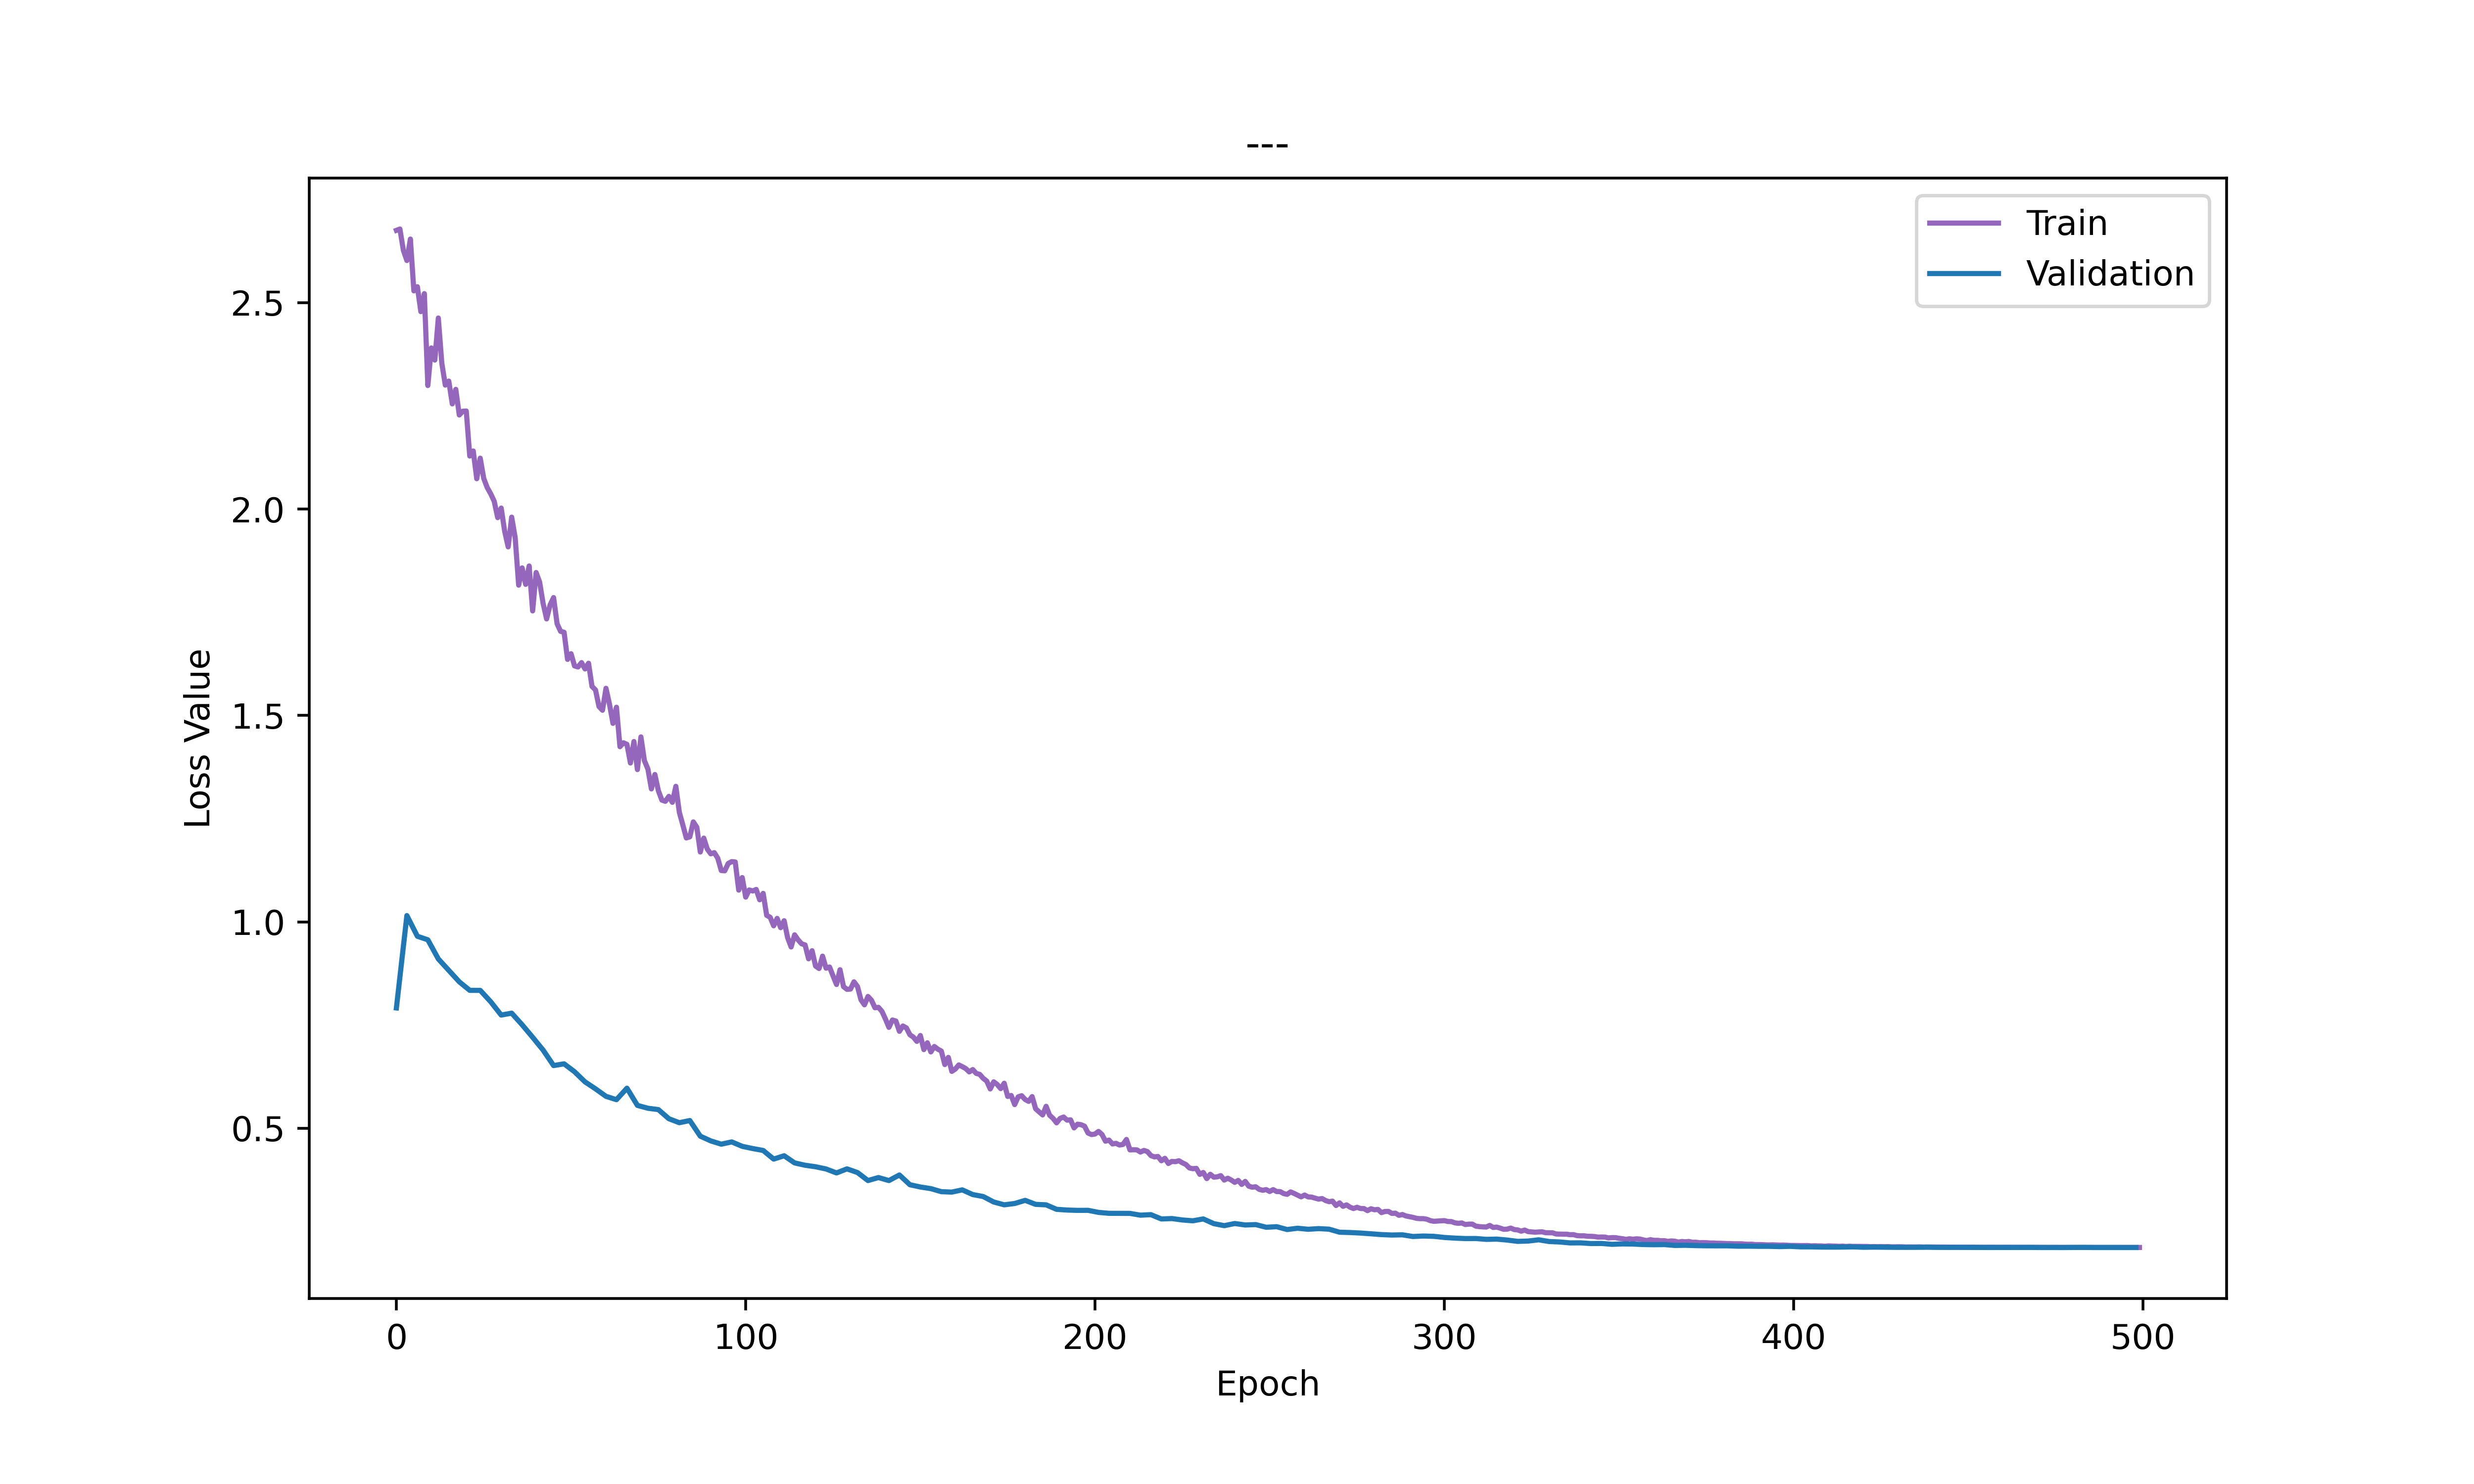

In [10]:
# CNN to Linear

In [11]:
"""
Created on Sun Dec 12, 2022
@author: talha.kilic
"""
# Variational AutoEncoder Model by means of PyTorch Support 


#library imports 
import torch.nn as nn
import torch.nn.functional as F
import torch 
# Macros
dropout_keep_rate= 0.66
features = 9
images_size = 96
channel_size = 16
#Paths
class VAEModel(nn.Module):
    
        #List of Modules
        conv = []
        dropout = []
        batch = []
        maxpooling = []
        
        size_after_cnv = channel_size*12*12

        dec = []
        dec_drop = []
        dec_batch = []

        def __init__(self):
            super(VAEModel, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=1,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv1)
            self.conv2 = nn.Conv2d(in_channels=channel_size,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv2)
            self.conv3 = nn.Conv2d(in_channels=channel_size,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv3)        
            self.conv4 = nn.Conv2d(in_channels=channel_size,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv4) 
            
            self.dropout1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout1)       
            self.dropout2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout2)     
            self.dropout3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout3)
            self.dropout4 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout4)
            
            
            self.batch1=nn.BatchNorm2d(channel_size) 
            self.batch.append(self.batch1)        
            self.batch2=nn.BatchNorm2d(channel_size)
            self.batch.append(self.batch2)
            self.batch3=nn.BatchNorm2d(channel_size)
            self.batch.append(self.batch3)            
            self.batch4=nn.BatchNorm2d(channel_size)
            self.batch.append(self.batch4)
            
            self.maxpooling1= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling1)
            self.maxpooling2= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling2)
            self.maxpooling3= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling3)
            self.maxpooling4= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling4)
            
            # Latent Space
            self.enc_lt1 = nn.Linear(in_features= self.size_after_cnv, out_features=features*2)
            
            # decoder 
            self.dec1 = nn.Linear(in_features=features, out_features=64)
            self.dec.append(self.dec1)
            self.dec2 = nn.Linear(in_features=64, out_features=256)
            self.dec.append(self.dec2)
            self.dec3 = nn.Linear(in_features=256, out_features=images_size*images_size)
            self.dec.append(self.dec3)


            self.dec_drop1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop1)
            self.dec_drop2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop2)
            self.dec_drop3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop3)

            
            self.dec_batch1 =nn.BatchNorm1d(64) 
            self.dec_batch.append(self.dec_batch1)
            self.dec_batch2 =nn.BatchNorm1d(256) 
            self.dec_batch.append(self.dec_batch2)
            self.dec_batch3 =nn.BatchNorm1d(images_size*images_size) 
            self.dec_batch.append(self.dec_batch3)
            
            
            

        def reparameterize(self, mean, log_var):
            
            epsilon = torch.randn_like(mean) 
            
            # z = mean + e*var
            return epsilon * torch.exp(log_var* 0.5) + mean 
        
        def sigmoid_loss(self,label,prediction):
            
            return label - label * prediction + torch.log(1 + torch.exp(-label))
        
        def log_normal_pdf(self,sample,mean,logvar):
            
            log2pi = torch.log(torch.tensor(2*torch.pi))
            sample = torch.tensor(sample).clone().detach()
            mean = torch.tensor(mean).clone().detach()
            logvar = torch.tensor(logvar).clone().detach()
            
            return  torch.sum(-0.5 * ((sample-mean)**2*torch.exp(-logvar) + logvar + log2pi))
            
        def calculate_loss(self,label,prediction,z,mean,logvar):
            
            cross_ent = self.sigmoid_loss(label,prediction)
            logpx_z = torch.sum(cross_ent)
            logpz = self.log_normal_pdf(z,0,0)
            logz_x = self.log_normal_pdf (z,mean,logvar)
            
            return -torch.mean(logpx_z + logpz - logz_x)

        def kl_loss(self,z,mean,logvar):
            
            kl_loss = torch.mean(-0.5 * (1 + logvar - torch.square(mean) - torch.exp(logvar)))
            
            return kl_loss
            
        def forward(self, x):

            #x = torch.flatten(x, start_dim=1)   
            
            x = x.reshape(-1,1,images_size,images_size)
            #Encoder Netwrok
            for i in range(3):
                #cnv
                x =  self.conv[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.batch[i](x)
                #print(f"{i}**",x.shape)
                
                #pooling
                x = self.maxpooling[i](x)
                
                # x = self.maxpooling[i](x)
                #print(f"{i}**",x.shape)
                x = self.dropout[i](x)
                
              
            # Flattening and decreasing    
            x = torch.flatten(x, start_dim=1)  
            x = self.enc_lt1(x)
            x = F.relu(x)
            
            # Latent Space
            x = x.view(-1, 2, features)
            mean = x[:, 0, :] # as  mean
            log_var = x[:, 1, :] #  as variance
            z = self.reparameterize(mean, log_var)
            
            
            #Decoder
            # x = z.reshape(-1,1,1,features)
            x = z
            
            for i in range(3):
                #cnv
                x = self.dec[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.dec_batch[i](x)
                #print(f"{i}**",x.shape)
                                
               
                #dropout
                if i == 2: #Last Layer 
                    # x = torch.flatten(x, start_dim=1) 
                    # x = self.dec[4](x)
                    out =  x.reshape(-1,images_size,images_size)
                else:
                    x = self.dec_drop[i](x)
                # print(f"{i}**",x.shape)
            


            return out, mean, log_var, z


if __name__ == "__main__":
    model = VAEModel()
    print(model.parameters)
    
    
    
    

<bound method Module.parameters of VAEModel(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (dropout1): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout2): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout3): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout4): Dropout2d(p=0.33999999999999997, inplace=False)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling1): MaxPool2d(kernel_size=2

Loss Function

Total Elapsed time is 69.828650 seconds.

---------------------TEST PROCESS------------------------------

test_loss= 0.2155069649219513

---------------------TEST PROCESS WITHOUT KL------------------------------

test_loss= 0.2155163288116455

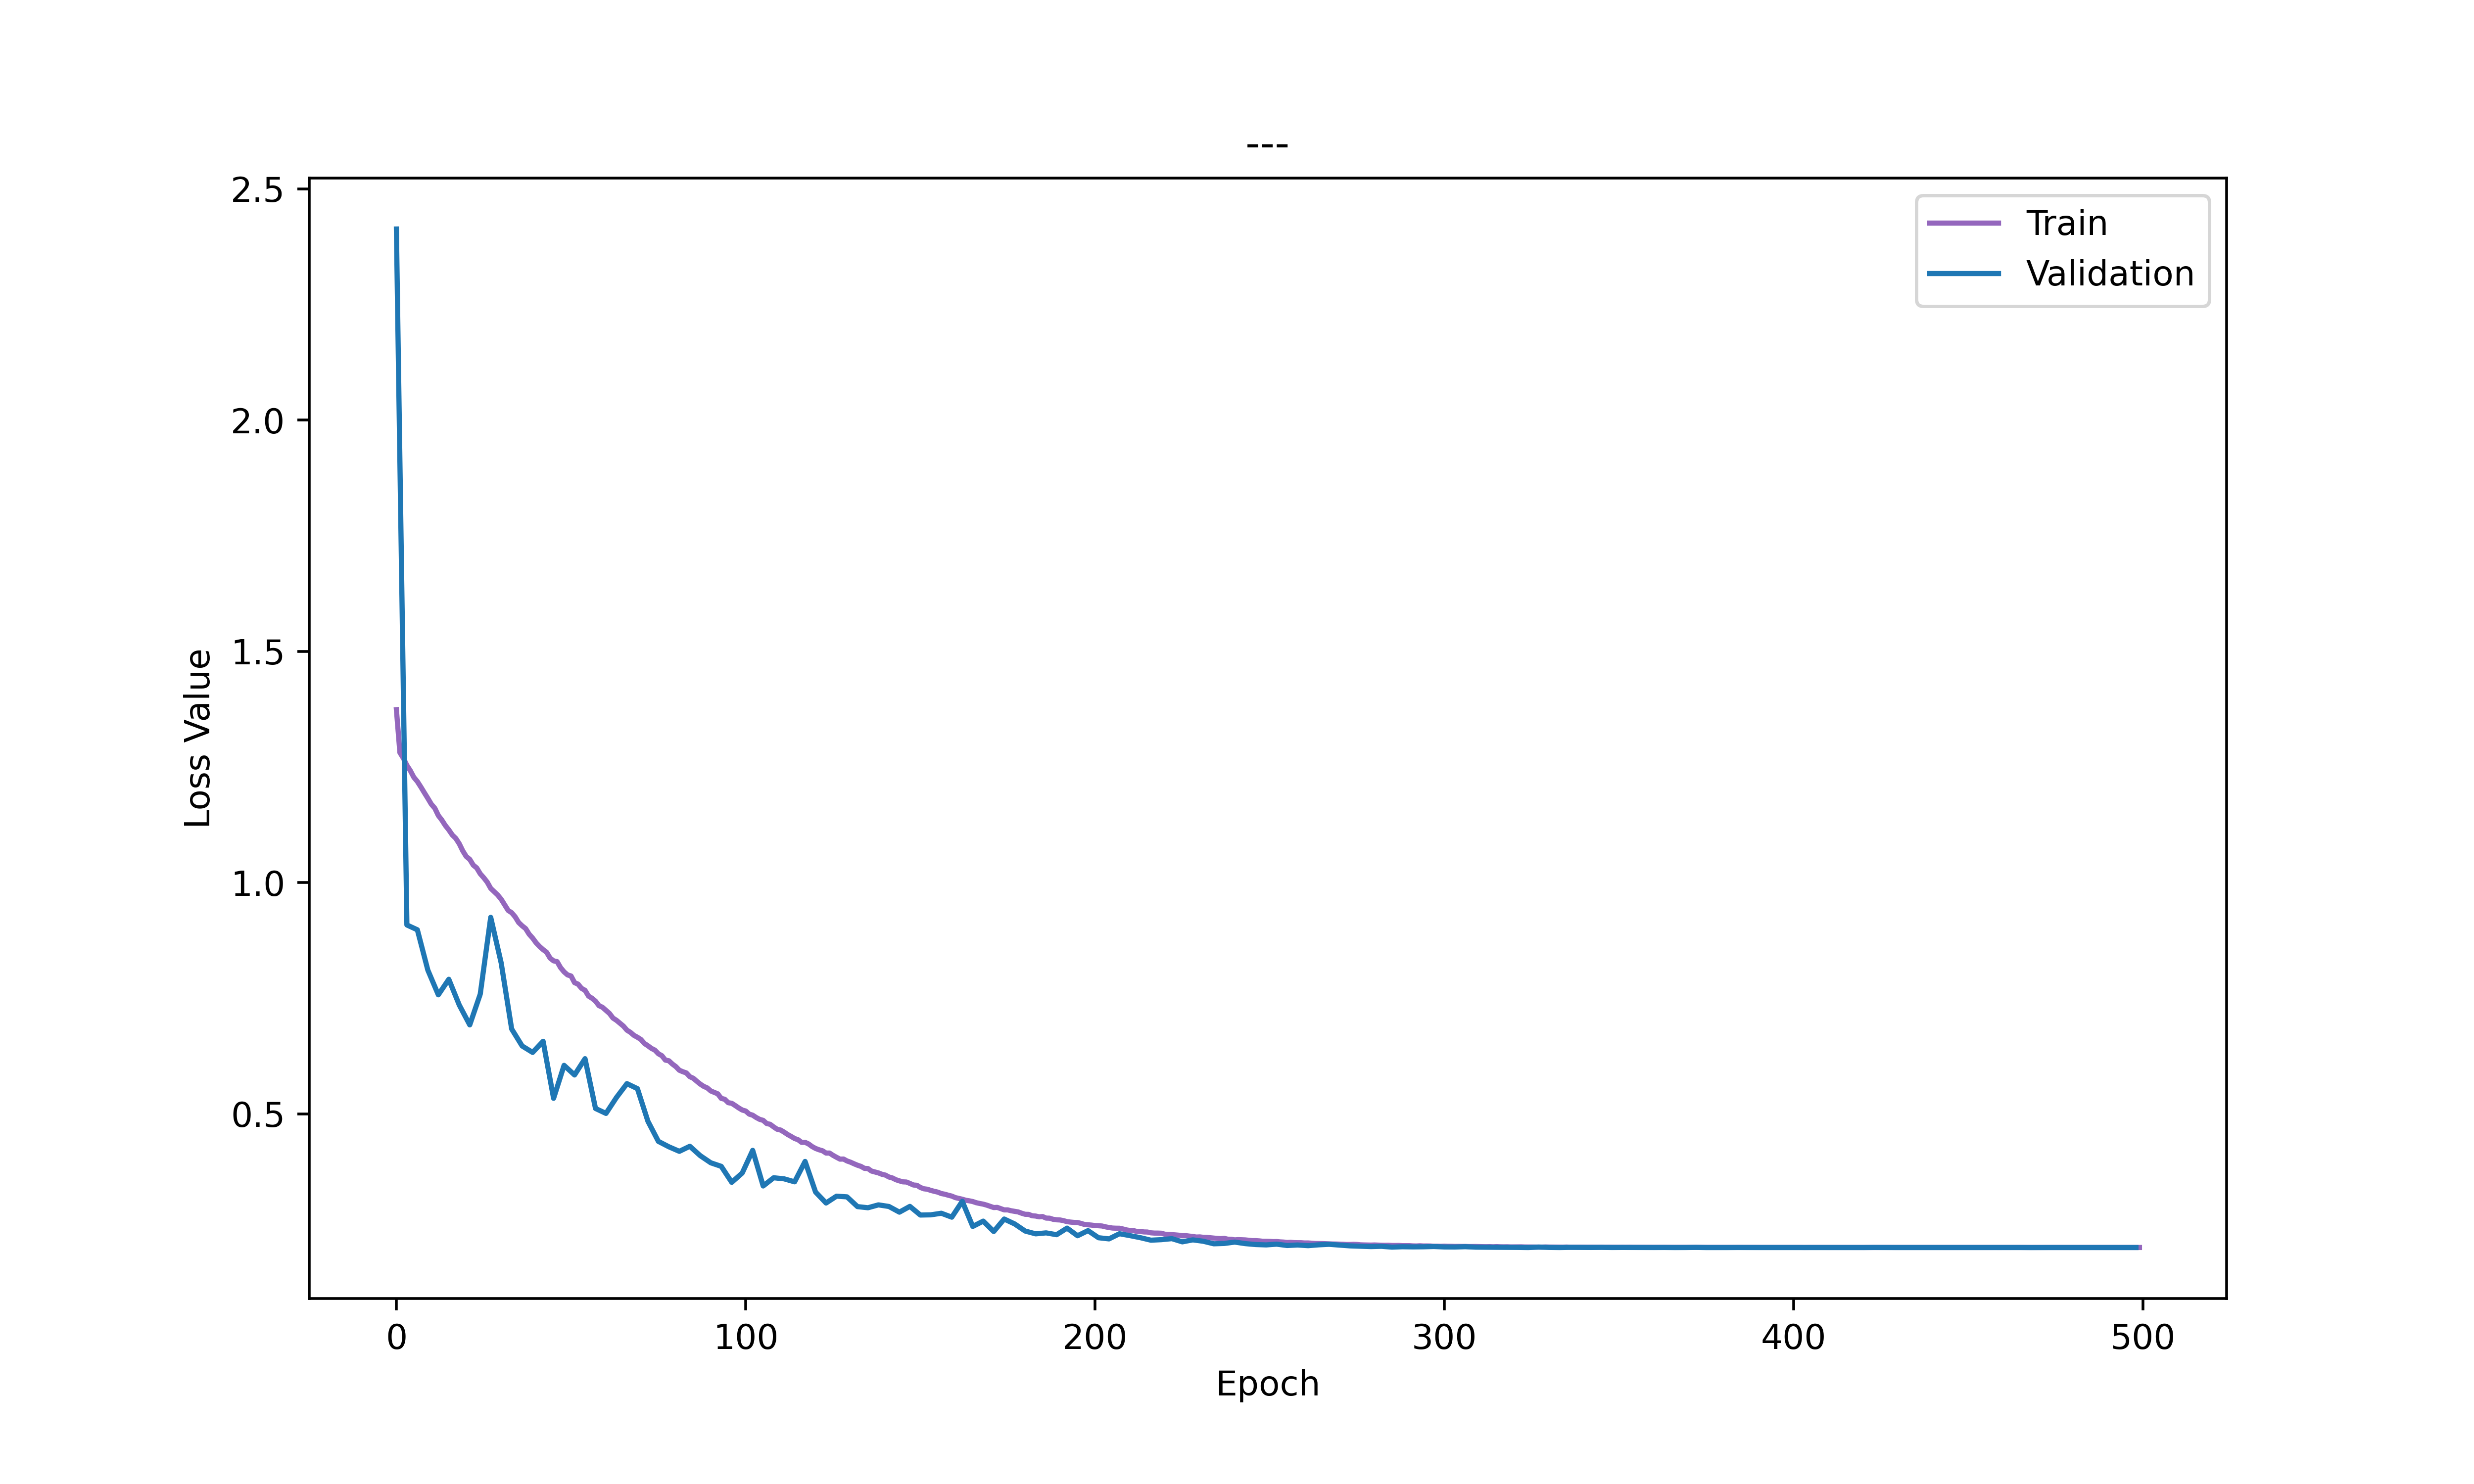


In [12]:
 #CNN to CNN

In [13]:
"""
Created on Sun Dec 12, 2022
@author: talha.kilic
"""
# Variational AutoEncoder Model by means of PyTorch Support 


#library imports 
import torch.nn as nn
import torch.nn.functional as F
import torch 
# Macros
dropout_keep_rate= 0.66
features = 9
images_size = 96
channel_size = 16
#Paths
class VAEModel(nn.Module):
    
        #List of Modules
        conv = []
        dropout = []
        batch = []
        maxpooling = []
        
        size_after_cnv = channel_size*12*12

        dec = []
        dec_drop = []
        dec_batch = []

        def __init__(self):
            super(VAEModel, self).__init__()
            
            self.conv1 = nn.Conv2d(in_channels=1,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv1)
            self.conv2 = nn.Conv2d(in_channels=channel_size,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv2)
            self.conv3 = nn.Conv2d(in_channels=channel_size,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv3)        
            self.conv4 = nn.Conv2d(in_channels=channel_size,out_channels=channel_size,kernel_size=4,stride=1,padding="same",bias=True)
            self.conv.append(self.conv4) 

            
            self.dropout1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout1)       
            self.dropout2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout2)     
            self.dropout3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout3)
            self.dropout4 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout4)

            
            
            self.batch1=nn.BatchNorm2d(channel_size) 
            self.batch.append(self.batch1)        
            self.batch2=nn.BatchNorm2d(channel_size)
            self.batch.append(self.batch2)
            self.batch3=nn.BatchNorm2d(channel_size)
            self.batch.append(self.batch3)            
            self.batch4=nn.BatchNorm2d(channel_size)
            self.batch.append(self.batch4)

            
            self.maxpooling1= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling1)
            self.maxpooling2= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling2)
            self.maxpooling3= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling3)
            self.maxpooling4= nn.MaxPool2d(2)
            self.maxpooling.append(self.maxpooling4)

            
            # Latent Space
            self.enc_lt1 = nn.Linear(in_features= self.size_after_cnv, out_features=features*2)
            
            # decoder 
            
            self.dec1 = nn.ConvTranspose2d(in_channels=1,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec1)
            self.dec2 = nn.ConvTranspose2d(in_channels=channel_size,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec2)
            self.dec3 = nn.ConvTranspose2d(in_channels=channel_size,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec3)
            self.dec4 =  nn.ConvTranspose2d(in_channels=channel_size,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec4)
            self.dec5= nn.Linear(in_features=2448, out_features=images_size*images_size)
            self.dec.append(self.dec5)
           


            self.dec_drop1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop1)
            self.dec_drop2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop2)
            self.dec_drop3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop3)
            self.dec_drop4 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop4)
 

            
            self.dec_batch1 = nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch1)
            self.dec_batch2 = nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch2)
            self.dec_batch3 = nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch3)
            self.dec_batch4 =  nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch4)
            

        def reparameterize(self, mean, log_var):
            
            epsilon = torch.randn_like(mean) 
            
            # z = mean + e*var
            return epsilon * torch.exp(log_var* 0.5) + mean 
        
        def sigmoid_loss(self,label,prediction):
            
            return label - label * prediction + torch.log(1 + torch.exp(-label))
        
        def log_normal_pdf(self,sample,mean,logvar):
            
            log2pi = torch.log(torch.tensor(2*torch.pi))
            sample = torch.tensor(sample).clone().detach()
            mean = torch.tensor(mean).clone().detach()
            logvar = torch.tensor(logvar).clone().detach()
            
            return  torch.sum(-0.5 * ((sample-mean)**2*torch.exp(-logvar) + logvar + log2pi))
            
        def calculate_loss(self,label,prediction,z,mean,logvar):
            
            cross_ent = self.sigmoid_loss(label,prediction)
            logpx_z = torch.sum(cross_ent)
            logpz = self.log_normal_pdf(z,0,0)
            logz_x = self.log_normal_pdf (z,mean,logvar)
            
            return -torch.mean(logpx_z + logpz - logz_x)

        def kl_loss(self,z,mean,logvar):
            
            kl_loss = torch.mean(-0.5 * (1 + logvar - torch.square(mean) - torch.exp(logvar)))
            
            return kl_loss
            
        def forward(self, x):

            #x = torch.flatten(x, start_dim=1)   
            
            x = x.reshape(-1,1,images_size,images_size)
            #Encoder Netwrok
            for i in range(3):
                #cnv
                x =  self.conv[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.batch[i](x)
                #print(f"{i}**",x.shape)
                
                #pooling
                x = self.maxpooling[i](x)
                
                # x = self.maxpooling[i](x)
                #print(f"{i}**",x.shape)
                x = self.dropout[i](x)
                
             
                
            # Flattening and decreasing
            x = torch.flatten(x, start_dim=1)  
            x = self.enc_lt1(x)
            x = F.relu(x)
            
            # Latent Space
            x = x.view(-1, 2, features)
            mean = x[:, 0, :] # as  mean
            log_var = x[:, 1, :] #  as variance
            z = self.reparameterize(mean, log_var)
            
            
            #Decoder
            x = z.reshape(-1,1,1,features)
            # x = z
            
            for i in range(4):
                #cnv
                x = self.dec[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.dec_batch[i](x)
                #print(f"{i}**",x.shape)
                                
               
                #dropout
                if i == 3: #Last Layer 
                    # x = torch.flatten(x, start_dim=1) 
                    # x = self.dec[4](x)
                    x = torch.flatten(x, start_dim=1) 
                    x = self.dec[4](x)
                    out =  x.reshape(-1,images_size,images_size)
                else:
                    x = self.dec_drop[i](x)
                # print(f"{i}**",x.shape)
            


            return out, mean, log_var, z


if __name__ == "__main__":
    model = VAEModel()
    print(model.parameters)

<bound method Module.parameters of VAEModel(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (dropout1): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout2): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout3): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout4): Dropout2d(p=0.33999999999999997, inplace=False)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling1): MaxPool2d(kernel_size=2

Loss Function

Total Elapsed time is 159.060699 seconds.

---------------------TEST PROCESS------------------------------

test_loss= 0.21585727334022523

---------------------TEST PROCESS WITHOUT KL------------------------------

test_loss= 0.21562145054340362

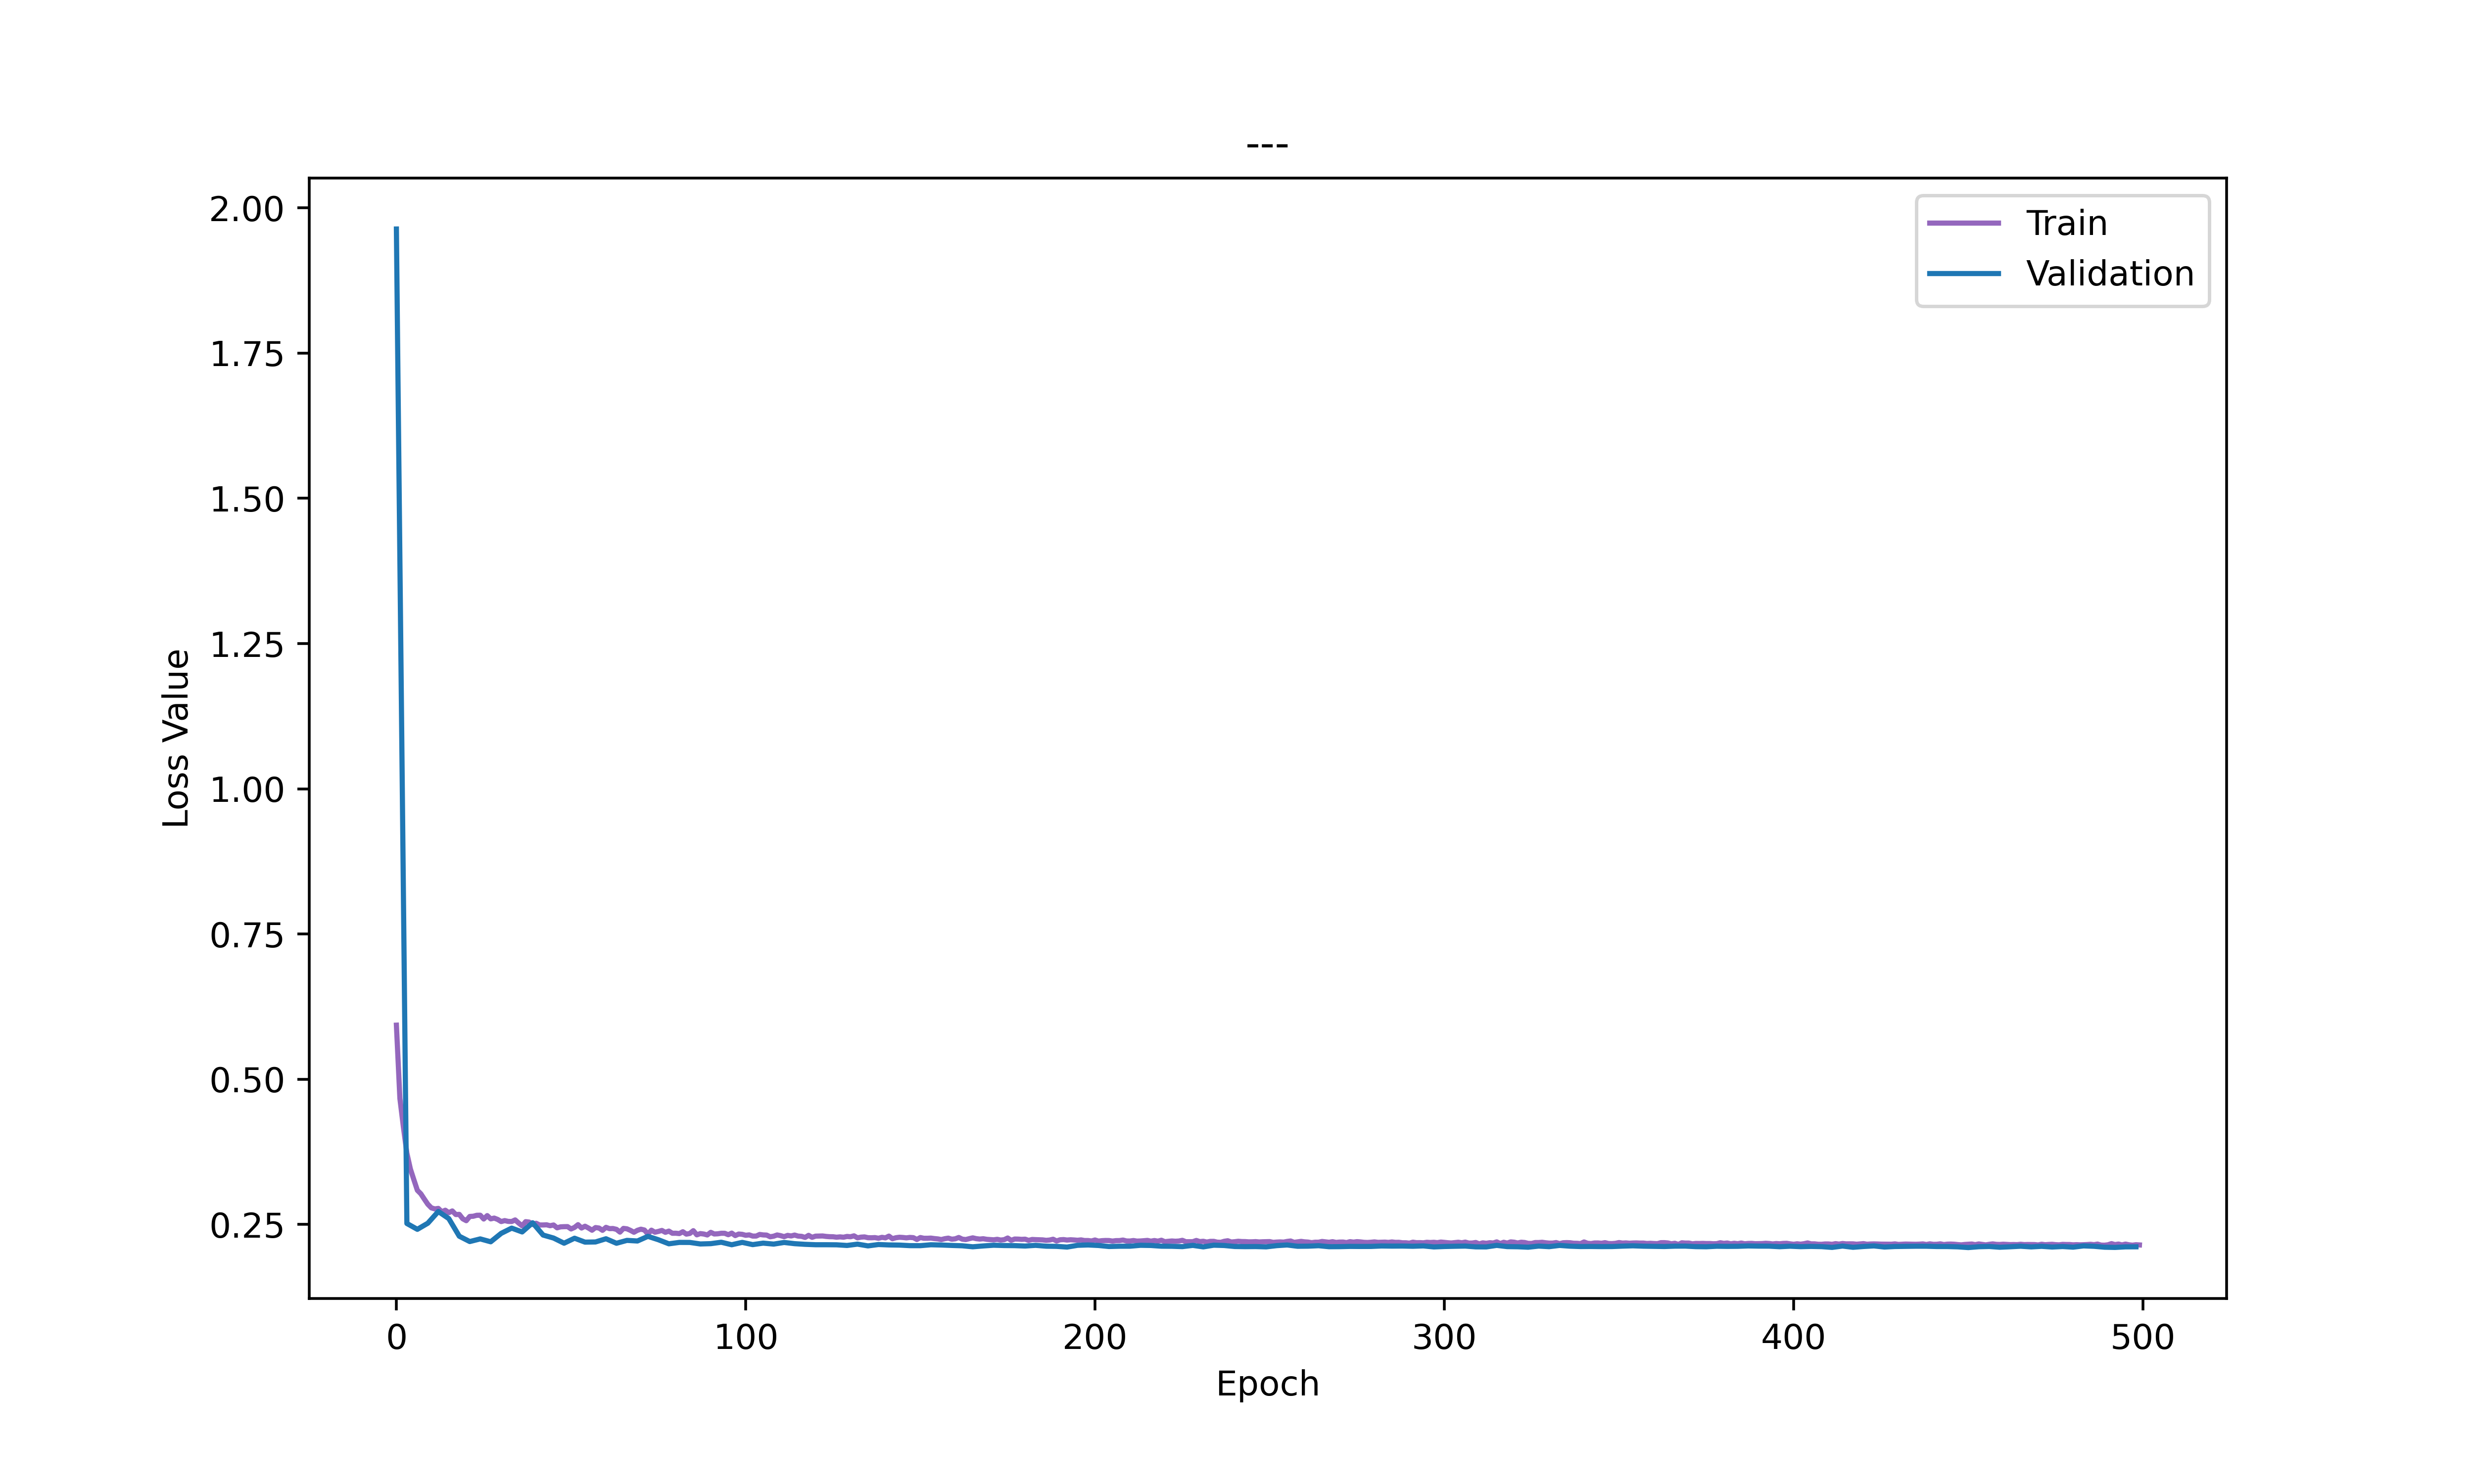

 In 100 epoch 

Total Elapsed time is 33.657874 seconds.

---------------------TEST PROCESS------------------------------

test_loss= 0.22239904403686522

---------------------TEST PROCESS WITHOUT KL------------------------------

test_loss= 0.22250491082668306

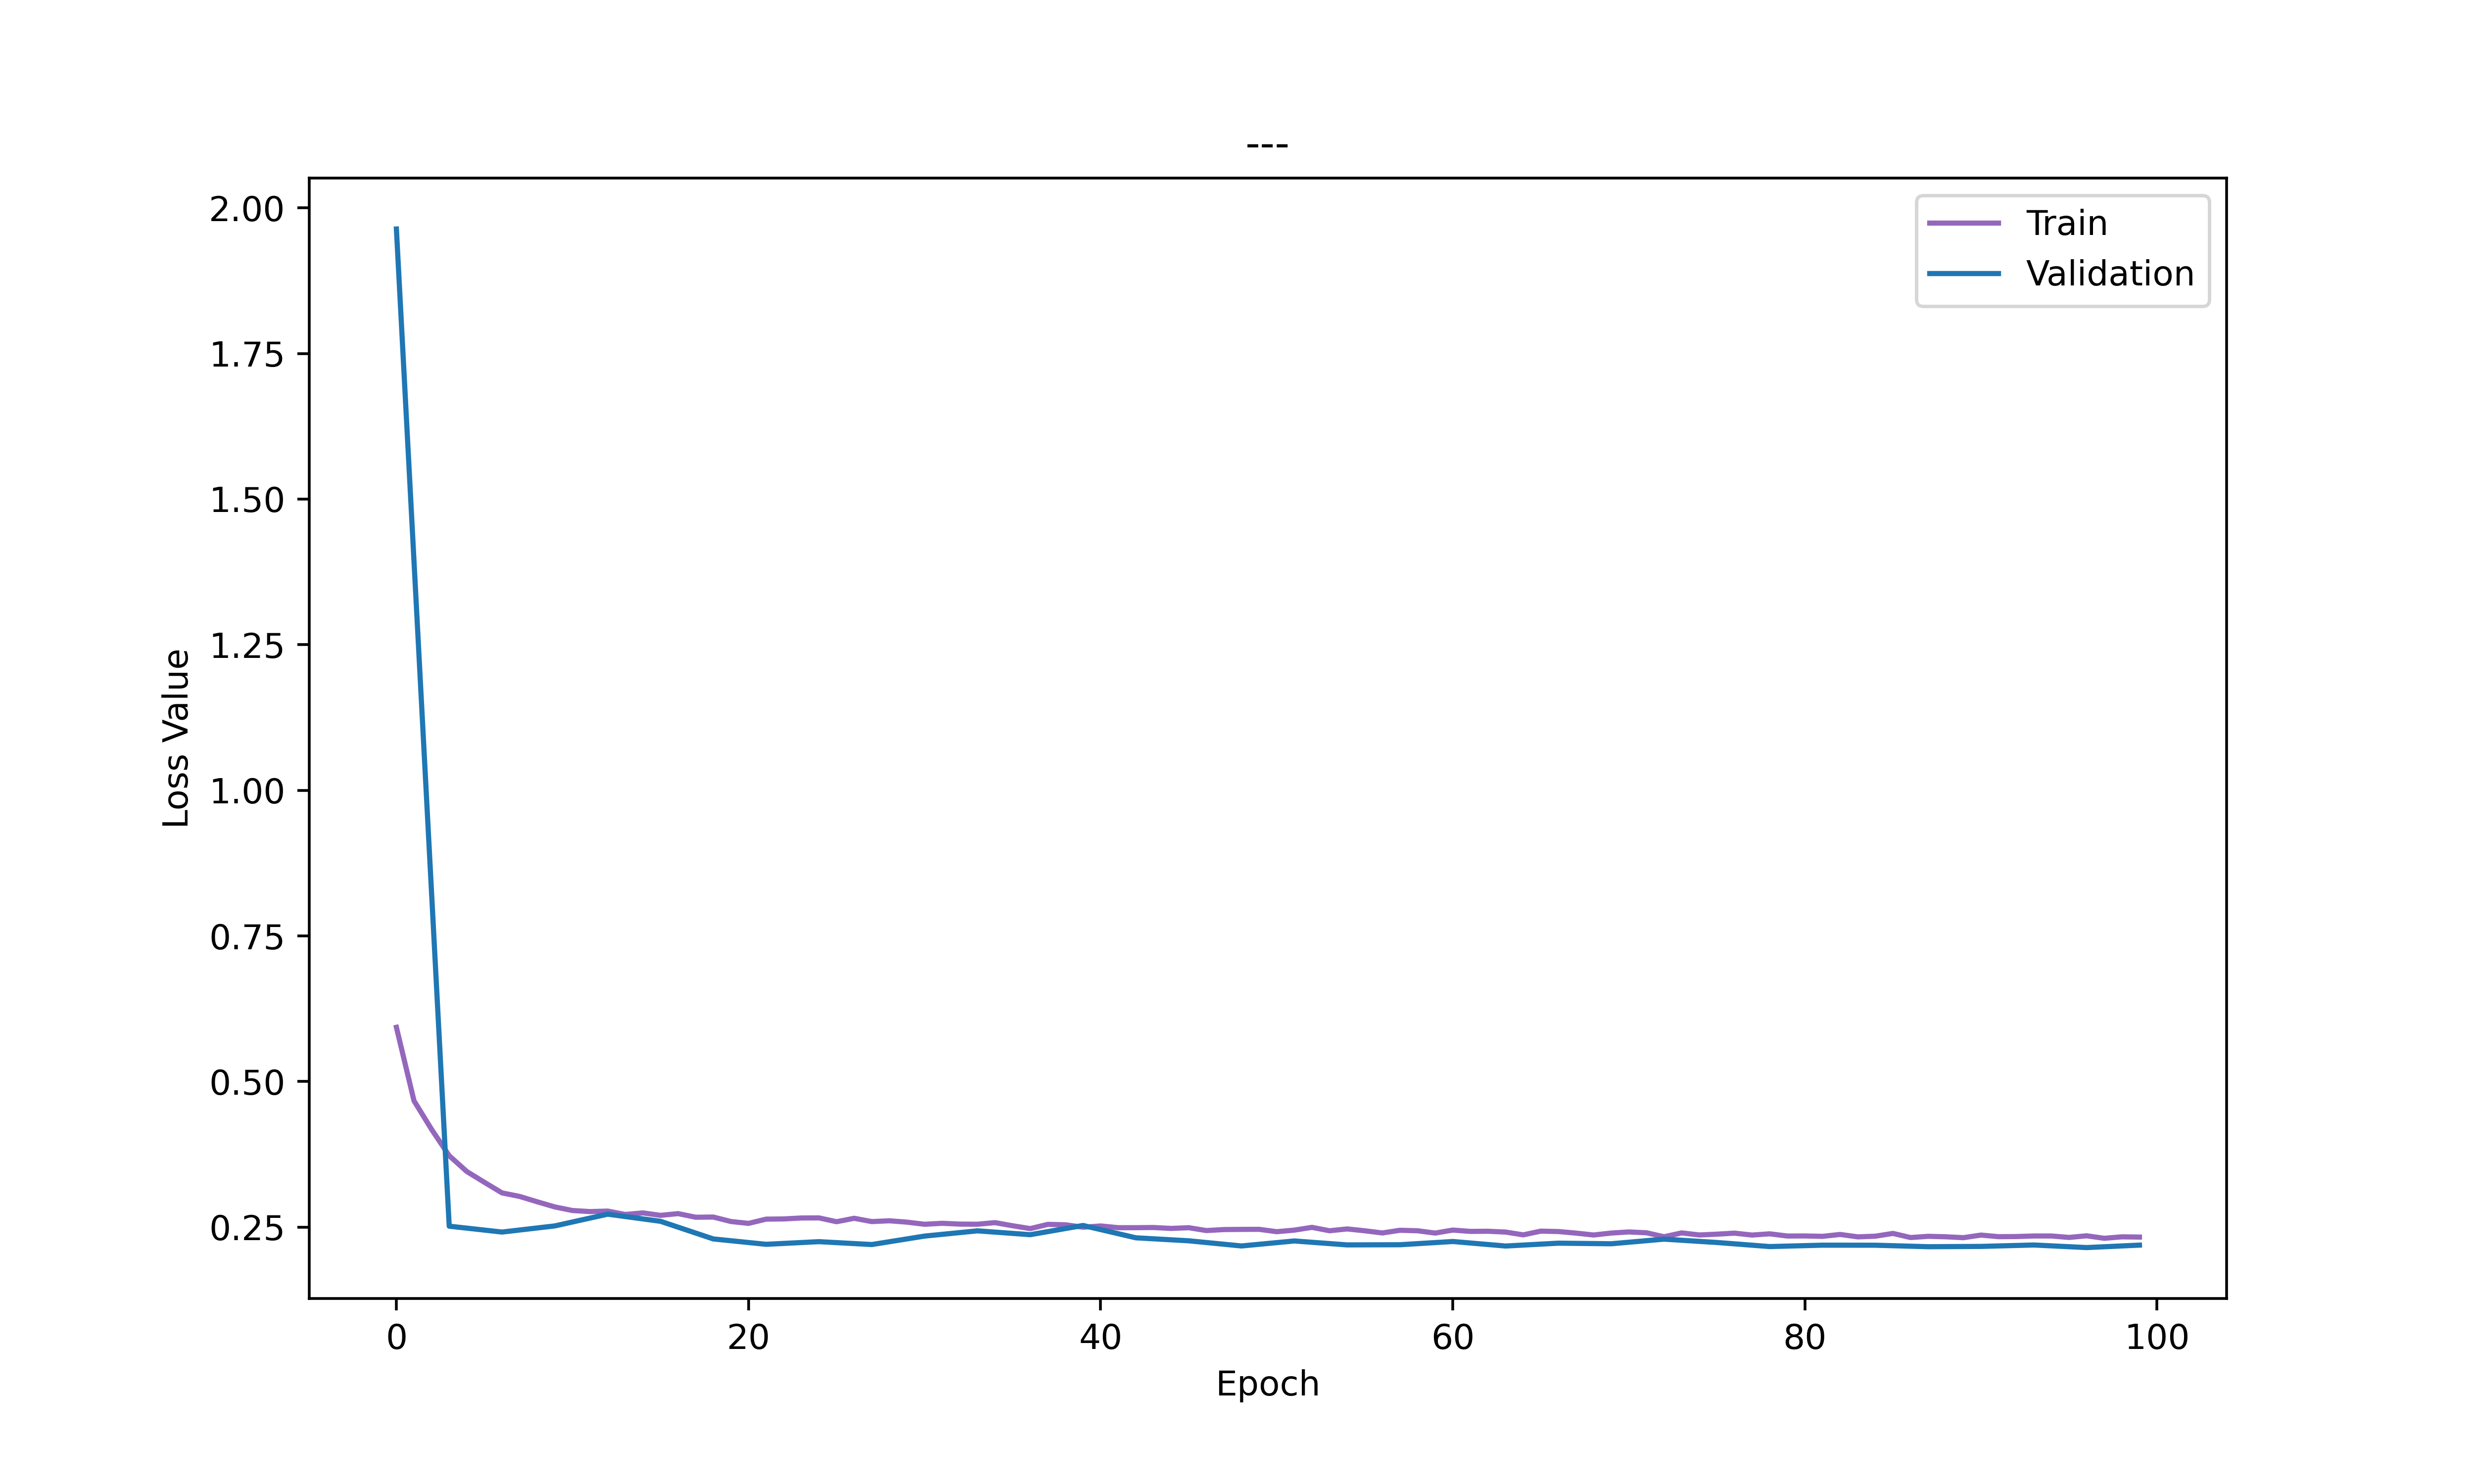
    

In [14]:
 #Dense to CNN

In [15]:
"""
Created on Sun Dec 12, 2022
@author: talha.kilic
"""
# Variational AutoEncoder Model by means of PyTorch Support 


#library imports 
import torch.nn as nn
import torch.nn.functional as F
import torch 
# Macros
dropout_keep_rate= 0.66
features = 9
images_size = 96
channel_size = 16
#Paths
class VAEModel(nn.Module):
    
        #List of Modules
        env = []
        dropout = []
        batch = []
        maxpooling = []
        
        size_after_cnv = channel_size*12*12

        dec = []
        dec_drop = []
        dec_batch = []

        def __init__(self):
            super(VAEModel, self).__init__()
            
            self.env1 = nn.Linear(in_features=images_size*images_size, out_features=256)
            self.env.append(self.env1)
            self.env2 = nn.Linear(in_features=256, out_features=64)
            self.env.append(self.env2)
            self.env3 =nn.Linear(in_features=64, out_features=features*2)
            self.env.append(self.env3)        

            self.dropout1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout1)       
            self.dropout2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout2)     
            self.dropout3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dropout.append(self.dropout3)
            
            self.batch1=nn.BatchNorm1d(256) 
            self.batch.append(self.batch1)        
            self.batch2=nn.BatchNorm1d(64)
            self.batch.append(self.batch2)
            self.batch3=nn.BatchNorm1d(features*2)
            self.batch.append(self.batch3)            

    
            # decoder 
            
            self.dec1 = nn.ConvTranspose2d(in_channels=1,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec1)
            self.dec2 = nn.ConvTranspose2d(in_channels=channel_size,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec2)
            self.dec3 = nn.ConvTranspose2d(in_channels=channel_size,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec3)
            self.dec4 =  nn.ConvTranspose2d(in_channels=channel_size,out_channels=channel_size,kernel_size=3,stride=1,bias=True)
            self.dec.append(self.dec4)
            self.dec5= nn.Linear(in_features=2448, out_features=images_size*images_size)
            self.dec.append(self.dec5)
           


            self.dec_drop1 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop1)
            self.dec_drop2 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop2)
            self.dec_drop3 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop3)
            self.dec_drop4 = nn.Dropout2d(1-dropout_keep_rate)
            self.dec_drop.append(self.dec_drop4)
 

            
            self.dec_batch1 = nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch1)
            self.dec_batch2 = nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch2)
            self.dec_batch3 = nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch3)
            self.dec_batch4 =  nn.BatchNorm2d(channel_size) 
            self.dec_batch.append(self.dec_batch4)
            

        def reparameterize(self, mean, log_var):
            
            epsilon = torch.randn_like(mean) 
            
            # z = mean + e*var
            return epsilon * torch.exp(log_var* 0.5) + mean 
        
        def sigmoid_loss(self,label,prediction):
            
            return label - label * prediction + torch.log(1 + torch.exp(-label))
        
        def log_normal_pdf(self,sample,mean,logvar):
            
            log2pi = torch.log(torch.tensor(2*torch.pi))
            sample = torch.tensor(sample).clone().detach()
            mean = torch.tensor(mean).clone().detach()
            logvar = torch.tensor(logvar).clone().detach()
            
            return  torch.sum(-0.5 * ((sample-mean)**2*torch.exp(-logvar) + logvar + log2pi))
            
        def calculate_loss(self,label,prediction,z,mean,logvar):
            
            cross_ent = self.sigmoid_loss(label,prediction)
            logpx_z = torch.sum(cross_ent)
            logpz = self.log_normal_pdf(z,0,0)
            logz_x = self.log_normal_pdf (z,mean,logvar)
            
            return -torch.mean(logpx_z + logpz - logz_x)

        def kl_loss(self,z,mean,logvar):
            
            kl_loss = torch.mean(-0.5 * (1 + logvar - torch.square(mean) - torch.exp(logvar)))
            
            return kl_loss
            
        def forward(self, x):

            x = torch.flatten(x, start_dim=1)   
            
            # x = x.reshape(-1,1,images_size,images_size)
            #Encoder Netwrok
            for i in range(3):
                #cnv
                x =  self.env[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.batch[i](x)
                #print(f"{i}**",x.shape)

                # x = self.maxpooling[i](x)
                #print(f"{i}**",x.shape)
                x = self.dropout[i](x)
                
             
            
            # Latent Space
            x = x.view(-1, 2, features)
            mean = x[:, 0, :] # as  mean
            log_var = x[:, 1, :] #  as variance
            z = self.reparameterize(mean, log_var)
            
            
            #Decoder
            x = z.reshape(-1,1,1,features)
            # x = z
            
            for i in range(4):
                #cnv
                x = self.dec[i](x)
                #print(f"{i}**",x.shape)
                
                 #relu
                x = F.relu(x)
                #print(f"{i}**",x.shape)
                
                 #batch
                x = self.dec_batch[i](x)
                #print(f"{i}**",x.shape)
                                
               
                #dropout
                if i == 3: #Last Layer 
                    # x = torch.flatten(x, start_dim=1) 
                    # x = self.dec[4](x)
                    x = torch.flatten(x, start_dim=1) 
                    x = self.dec[4](x)
                    out =  x.reshape(-1,images_size,images_size)
                else:
                    x = self.dec_drop[i](x)
                # print(f"{i}**",x.shape)
            


            return out, mean, log_var, z


if __name__ == "__main__":
    model = VAEModel()
    print(model.parameters)

<bound method Module.parameters of VAEModel(
  (env1): Linear(in_features=9216, out_features=256, bias=True)
  (env2): Linear(in_features=256, out_features=64, bias=True)
  (env3): Linear(in_features=64, out_features=18, bias=True)
  (dropout1): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout2): Dropout2d(p=0.33999999999999997, inplace=False)
  (dropout3): Dropout2d(p=0.33999999999999997, inplace=False)
  (batch1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec1): ConvTranspose2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec3): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec4): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (dec5): Linear(in_features=2

Total Elapsed time is 147.929839 seconds.

---------------------TEST PROCESS------------------------------

test_loss= 0.21564652323722838

---------------------TEST PROCESS WITHOUT KL------------------------------

test_loss= 0.21585377156734467

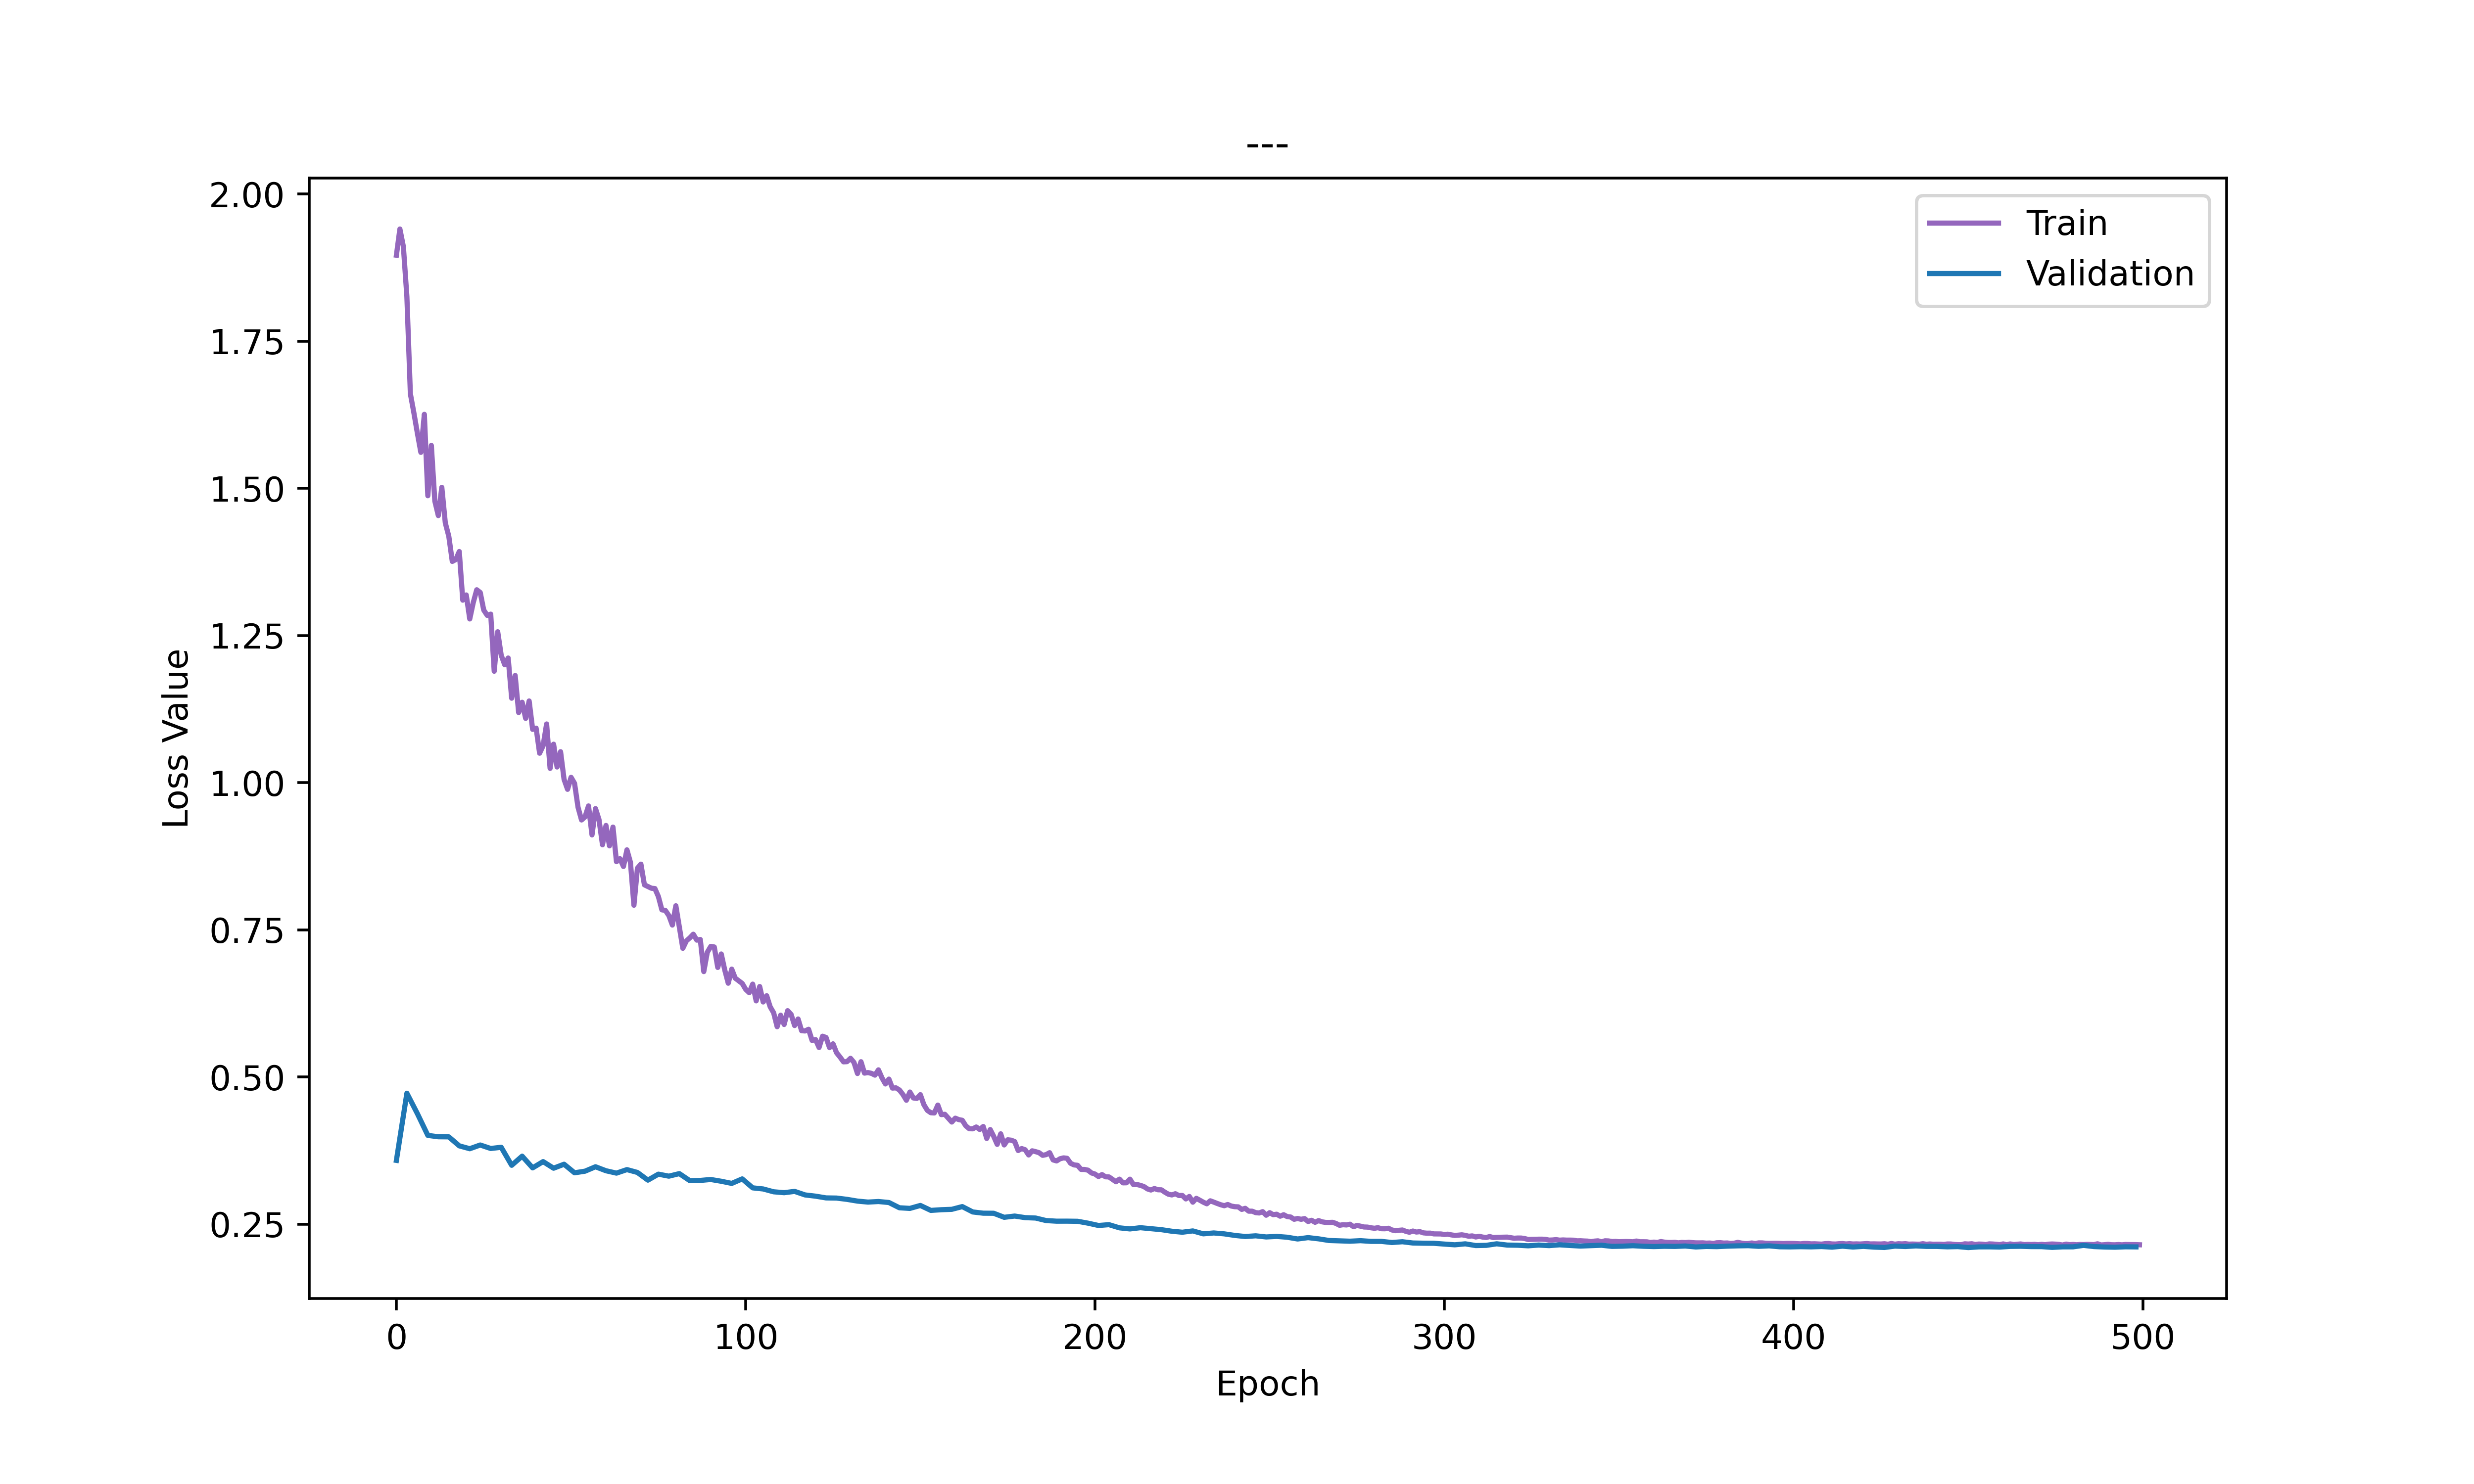

| Model Name | Time Consumed  | Test Loss with KL Divergence | Test Loss wıthout KL Divergence |
| --- | --- | --- |--- |
| Dense-Sense | 57.054769 seconds | 0.21560066938400269 |0.21553832292556763 |
| Dense-CNN| 147.929839 seconds | 0.21564652323722838 | 0.21585377156734467 |
| CNN-CNN | 159.060699 seconds | 0.21585727334022523 | 0.21562145054340362 |
| CNN-Dense | 69.828650 seconds | 0.2155069649219513 | 0.2155163288116455 |

In [17]:
from IPython.core.display import display, HTML
from PIL import Image
import cStringIO
import base64
import pandas as pd

ModuleNotFoundError: No module named 'cStringIO'